# DSCI 572 lecture 3

#### Extra dependencies:

- autograd: `pip install autograd`

In [1]:
import sklearn
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.optimize

import autograd # pip install autograd
from autograd import grad
import autograd.numpy as np

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
%autosave 0

Autosave disabled


What if we are optimizing a function and we don't know its derivative/gradient. This could happen because

- you're optimizing the parameters of a computer simulation 
  - a robot
  - weather / atmospheric science
  - financial simulation
  - ...
- you're optimizing the hyperparameters of a machine learning algorithm
- the derivative is just too much effort to compute and it's slowing down your prototyping efforts
- ...

What to do??

There are 3 main approaches to computing derivatives with a computer

- symbolic differentiation

- numerical differentiation

- automatic differentiation



As a running example, consider $f(x)=\sin(x)$. We know that $f'(x)\equiv\frac{df(x)}{dx}=\cos(x)$ and thus $f'(1)=\cos(1)$

## Symbolic differentiation

- Interpret the symbols and apply the rules of differentiation, sort of like a human does

- Wolfram Alpha is a good tool: see <https://www.wolframalpha.com/input/?i=derivative+of+sin(x)>

- A useful tool, but less so when deadling with data.

- We will not say more about this now. You should be aware of its existence.


## Numerical differentiation (with finite differences)


- a derivative is defined as

$$\frac{df(x)}{dx} \equiv \lim_{h\rightarrow 0} \frac{f(x+h)-f(x)}{h} $$

- numerical differentiation: do this even though $h$ is only small and not actually infinitesimal

$$\frac{df(x)}{dx} \approx \frac{f(x+h)-f(x)}{h}$$ for small $h$. This is called **finite differences**.

Let's give it a try!

In [4]:
h = 0.001
f = np.sin
x0 = 1
dfdx = (f(x0+h)-f(x0))/h
dfdx

0.5398814803603269

In [5]:
np.cos(x0)

0.5403023058681398

Not bad!

#### Error of derivative estimates

- In the last lecture we discussed numerical issues due to the **floating point** representation.

- There's an entirely different type of numerical error that arises from **discretization**.




Question for all y'all: what do you think will happen to the absolute error of the estimate if I change $h$?

Definition: 

let $f'(1)$ be the true derivative at $x=1$ and $\hat{f'}(1)$ be the estimate. Then the absolute error is defined as

$$\left|f'(1)-\hat{f'}(1)\right|$$

Discuss for a few minutes. 

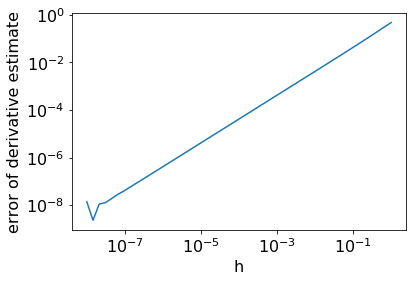

In [31]:
# here's the code
f = lambda x: np.sin(x)
dfdx_estimate = lambda h: (f(x0+h)-f(x0))/h
dfdx_true = np.cos(x0)
abs_error = lambda h: np.abs(dfdx_estimate(h)-dfdx_true)

h = 10**(np.linspace(-8,0))
plt.loglog(h, abs_error(h));
plt.xlabel('h')
plt.ylabel("error of derivative estimate");

Makes sense, right? But the plot thickens when we look at smaller values of $h$...

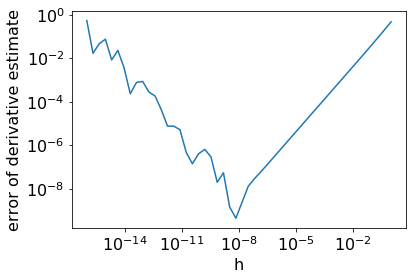

In [32]:
h = 10**(np.linspace(-16,0))
plt.loglog(h, abs_error(h))
plt.xlabel('h')
plt.ylabel("error of derivative estimate");

Wait... what? Discuss...

- Recall lecture 3 (last time). When $h\ll 1$ we have that $\left| f(x+h)-f(x) \right| \ll 1$. This leads to _roundoff errors_. Is it underflow?

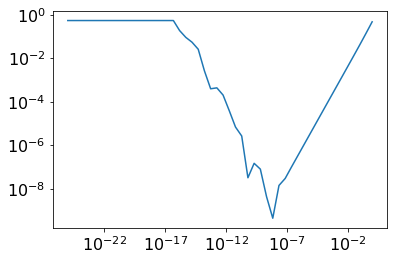

In [33]:
h = 10**(np.linspace(-25,0))
plt.loglog(h, abs_error(h));

So, no, the flat part is underflow (estimate of the derivative is exactly zero). What's up with the part in between, from $h=10^{-16}$ to $10^{-7}$?

- The problem is regular old roundoff error.

- Roughly speaking, the magnitude of these roundoff errors is independent of $h$ (e.g. when computing $f(x)$ it has nothing to do with $h$), and so the $h$ in the denominator causes $\frac{1}{h}$-like behavior.

- We can test this with a line, using our friend $10^{-16}$ from last lecture 
  - (optional) it's actually $2^{-53}$... 52 bits in the mantissa means spacing on the order of $2^{-52}$, which means roundoff error of $2^{-53}$.

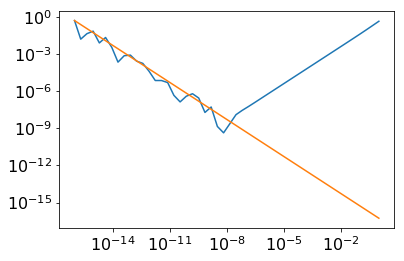

In [34]:
h = 10**(np.linspace(-16,0))
plt.loglog(h, abs_error(h))
plt.loglog(h, 1e-16*dfdx_true/h);

We won't go into the details of how we calculated the line, but we can see the the slope is indeed around 1. We can also look at the other line, which follows our intuition that a small $h$ is good...

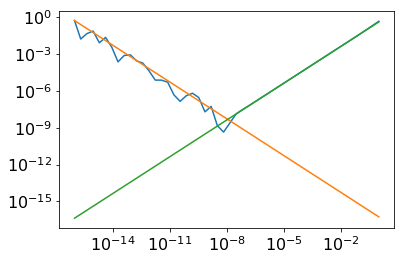

In [35]:
h = 10**(np.linspace(-16,0))
plt.loglog(h, abs_error(h))
plt.loglog(h, 1e-16*abs(dfdx_true)/h)
d2fdx2_true = -np.sin(x0) # don't worry about this
plt.loglog(h, abs(d2fdx2_true)/2*h);

Wow!

What have we learned?

- the _numerical approximation_ to the derivative initially increases as $h$ gets smaller (this effect is linear in $h$)

- however, when $h$ is too small then roundoff error kicks in and the error starts to increase (this effect is linear in $1/h$)


What you really need to know: picking $h$ is tricky: it can't be too big or too small.

#### Gradients 

- What about gradients?
- In this case, 

$$\nabla f(x) = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \\ \vdots \\ \frac{\partial f}{\partial x_d} \end{bmatrix}$$ 

We approximate each partial derivative as





$$\frac{\partial f(x)}{\partial x_1} \approx \frac{f(x+h e_1)-f(x)}{h}$$ 

where $e_1 = \begin{bmatrix}1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}$. 

In general, $$\frac{\partial f(x)}{\partial x_j} \approx \frac{f(x+h e_j)-f(x)}{h}$$ 

where $e_j$ is $1$ at position $j$ and zero elsewhere.

Put another way (if this helps),

$$\frac{\partial f(x)}{\partial x_1} \approx \frac{f\left(\begin{bmatrix}x_1 + h \\ x_2 \\ x_3 \\ \vdots \\ x_d \end{bmatrix} \right)-f(x)}{h}$$ 

$$\frac{\partial f(x)}{\partial x_2} \approx \frac{f\left(\begin{bmatrix}x_1 \\ x_2 + h \\ x_3 \\ \vdots \\ x_d \end{bmatrix} \right)-f(x)}{h}$$ 

etc.

#### Cost of estimating a gradient

- Estimating a gradient requires $d+1$ function evaluations. 

- That can be expensive. Perhaps $d$ is $1000$ or $10000$.

- If you can compute the gradient symbolically, that is much better.

- (optional) It turns out evaluating $f$ and evaluating $\nabla f$ take the same amount of time in general. For example, with OLS evaluating the loss $\sum_{i=1}^n (w^T x_i - y_i)^2$ takes $O(nd)$ time (sum over $n$, dot product over $d$ dimensions). And evaluating the gradient $X^TXw-X^Ty$ also takes $O(nd)$ time if you are clever and evaluate it as $X^T(Xw)-X^Ty$ (matrix-vector product takes $O(nd)$, we do 3 of them). It's a bit surprising that computing $f$ (a number) takes about the same amount of time as computing $\nabla f$ (a vector), but such is life.

#### (optional) Other finite difference formulas

- There are better finite differences formulas than the one we are using, such as 

$$\frac{df(x)}{dx} \approx \frac{f(x+h)-f(x-h)}{2h}$$

- this is called the centered difference formula.
- in this case the error goes down as $h^2$, which is great.
- but most of the benefits come in applications that don't concern us here (e.g., solving differential equations). 
- But, in $d$ dimensions, this requires $2d$ evaluations of the function instead of $d+1$, because with the forward difference formula (the original one above) we reuse the point $f(x)$ for all the partial derivatives.
- Conclusion: which formula you use depends on what you're doing.

If you're really bored, you can also check out the [complex step method](https://timvieira.github.io/blog/post/2014/08/07/complex-step-derivative/).

#### Summary

- If we can't figure out the derivative of a function, but have code that computes the function, we can _approximate_ the derivative using finite differences.

- This works pretty well but there are some pitfalls. In particular you need to choose $h$ carefully and it costs $O(d)$ function evaluations to estimate a gradient.

- It seems better to actually know the derivative if possible, because the computations will be faster and more accurate.


## Automatic differentiation (AD)

- AD is another way to take the derivative given some code that computes $f$
- It is advertised as the "best of both worlds" between symbolic and numerical differentiation
  - Pro: takes the code as input, not math.
  - Pro: does not have the problem of choosing $h$, or the extra $O(d)$ cost.
  - Con: some AD software packages have limitations, hurt code readability.
  - Con: large space complexity.

(optional stuff) 

- There are two main types, _forward mode_ and _reverse mode_ AD. We'll be discussing reverse mode.
- AD keeps track of the gradient of primitive operations
- Then it apply the chain rule

- We'll use a package called AutoGrad (above: `from autograd import grad`).
- TensorFlow (next week) also uses AD.

Demonstration 1: $\sin(x)$

In [11]:
np.cos(1.0)

0.5403023058681398

In [12]:
grad(np.sin)(1.0)

0.5403023058681398

Above: AutoGrad's `grad` takes in a Python function, and returns another Python function that computes the gradient.

Functions from lab 1:

In [13]:
x = np.random.rand(4)

def foo(x):
    return np.sum(x)

def foo_grad(x):
    return np.ones(len(x)) ## SOLUTION

foo_grad(x)

array([1., 1., 1., 1.])

In [14]:
foo_grad_AD = grad(foo)
foo_grad_AD(x)

array([1., 1., 1., 1.])

In [15]:
def pin(x):
    return np.sin(x[1])

def pin_grad(x):
    grad = np.zeros(len(x)) ## SOLUTION
    grad[1] = np.cos(x[1])
    return grad

pin_grad(x)

array([0.        , 0.97793638, 0.        , 0.        ])

In [16]:
pin_grad_AD = grad(pin)
pin_grad_AD(x)

array([0.        , 0.97793638, 0.        , 0.        ])

So what happened here is that autograd knows how to deal with things like `np.sum`, `np.abs`, subtraction, addition, etc. And it just applied the chain rule for us. 

But let's make sure it wasn't cheating and just doing numerical differentiation!!!

In [17]:
def pin(x):
    print("Evaluated function!") # let us know what it's doing
    return np.sin(x[1])

def pin_grad(x):
    grad = np.zeros(len(x)) ## SOLUTION
    grad[1] = np.cos(x[1])
    return grad

If it were doing numerical differentiation, it would need to evaluation the function $d+1$ times (5 times in this case)

In [18]:
scipy.optimize.approx_fprime(x, pin, 1e-6) # do numerical differentiation

Evaluated function!
Evaluated function!
Evaluated function!
Evaluated function!
Evaluated function!


array([0.        , 0.97793628, 0.        , 0.        ])

In [19]:
pin_grad_AD = grad(pin) # automatic differentiation
pin_grad_AD(x)

Evaluated function!


array([0.        , 0.97793638, 0.        , 0.        ])

Bam!

In [20]:
def baz(x):
    result = 0
    for i in range(len(x)):
        result = result + x[i]**i
    return result

def baz_grad(x):
    result = [0] ## SOLUTION
    for i in range(1,len(x)):
        result.append(i*x[i]**(i-1))
    return result

baz_grad(x)

[0, 1.0, 0.1675939546530234, 0.7398811348271392]

In [21]:
baz_grad_AD = grad(baz) # differentiate through `for` loops!
baz_grad_AD(x)

array([0.        , 1.        , 0.16759395, 0.73988113])

In [22]:
def bar(x):
    if np.abs(x[1]) > 2:
        return 0
    else:
        return -(x[0]*x[0]+1)*np.cos(x[1]-1)

def bar_grad(x):
    if np.abs(x[1]) > 2: ## SOLUTION
        return np.zeros(len(x))
    else:
        result = 0*x
        result[0] = -2*x[0]*np.cos(x[1]-1)
        result[1] = (x[0]*x[0]+1)*np.sin(x[1]-1)
        return result
    
bar_grad(x)

array([-0.84272225, -0.96427028,  0.        ,  0.        ])

In [23]:
bar_grad_AD = grad(bar) # differentiate through `if` statements!
bar_grad_AD(x)

array([-0.84272225, -0.96427028,  0.        ,  0.        ])

Demonstration 2: robust regression with the Huber loss (whose derivative I don't really feel like dealing with).

In [24]:
d = 10
n = 1000

# generate random data
X = np.random.randn(n,d)
w_true = np.random.randn(d)
y = X@w_true
# add random outliers
Noutliers = 50
y[:Noutliers] += 100*np.random.randn(Noutliers)
w_true

array([ 0.1031096 , -0.72004712, -1.04463879, -0.60584301, -0.82583228,
        2.10965657,  1.49386766, -0.67711508,  0.06653525, -0.99457454])

In [25]:
from sklearn.linear_model import HuberRegressor

hr = HuberRegressor(fit_intercept=False, alpha=0)
hr.fit(X,y)
hr.coef_

array([ 0.10310968, -0.7200472 , -1.04463895, -0.605843  , -0.82583228,
        2.10965665,  1.49386773, -0.67711502,  0.06653524, -0.99457453])

In [26]:
huber = lambda z: 0.5*z**2*(np.abs(z)<=1) + (np.abs(z)-0.5)*(np.abs(z)>1)
f = lambda w: np.sum(huber(X@w-y))

Get ready...


In [27]:
df_dw = grad(f) # differentiate through matrix multiplications, etc.

In [28]:
w = np.zeros(d)

alpha = 0.001
while np.linalg.norm(df_dw(w)) > 0.0001:
    w -= alpha*df_dw(w)
    
w

array([ 0.08852632, -0.72731365, -1.0403564 , -0.60301123, -0.81504508,
        2.10870362,  1.49309668, -0.68657256,  0.05758337, -1.00171282])

Nice! (They are not exactly the same because of `epsilon` hyperparameter in `HuberRegressor`.)


#### Do I never need to take a derivative again?
    
- For prototyping, no. 
- For production / real-time applications, hopefully not? 
  - There are production-grade automatic differentiation systems, like TensorFlow.
    
Limitations of Autograd specifically:

- Many but not all NumPy functions are in there. If you have a new one you'll need to contribute to Autograd.
- There are some actual limitations on the code, like assigning to arrays.
- You have to use Python/NumPy.

Limitations of AD generally:

- Possible restrictions on programming language, code, code style.
- Memory requirements.